# **Initial Data Exploration - CMSC320 Project Milestone 2**

Requirements are listed [here](https://acrobat.adobe.com/link/review?uri=urn%3Aaaid%3Ascds%3AUS%3A1a28f442-fc75-341a-990f-af6d7aec3950).

# Data Preprocessing

The first thing we need to do is preprocess the data.

In [173]:
import pandas as pd
import seaborn as sns

In [174]:
df= pd.read_csv("data/netflix-rotten-tomatoes-metacritic-imdb.csv")

In [175]:
print(df.columns)
print(len(df))

Index(['Title', 'Genre', 'Tags', 'Languages', 'Series or Movie',
       'Hidden Gem Score', 'Country Availability', 'Runtime', 'Director',
       'Writer', 'Actors', 'View Rating', 'IMDb Score',
       'Rotten Tomatoes Score', 'Metacritic Score', 'Awards Received',
       'Awards Nominated For', 'Boxoffice', 'Release Date',
       'Netflix Release Date', 'Production House', 'Netflix Link', 'IMDb Link',
       'Summary', 'IMDb Votes', 'Image', 'Poster', 'TMDb Trailer',
       'Trailer Site'],
      dtype='object')
15480


Here are the percentages of each column which are NaN.

This could be an issue, many of these columns are probably basically unusable.

In [176]:
df.isna().sum() / df.shape[0]

Title                    0.000000
Genre                    0.110465
Tags                     0.004328
Languages                0.126227
Series or Movie          0.000000
Hidden Gem Score         0.135724
Country Availability     0.001227
Runtime                  0.000065
Director                 0.304134
Writer                   0.279716
Actors                   0.124354
View Rating              0.453747
IMDb Score               0.135594
Rotten Tomatoes Score    0.587726
Metacritic Score         0.719897
Awards Received          0.607558
Awards Nominated For     0.505103
Boxoffice                0.741150
Release Date             0.136111
Netflix Release Date     0.000000
Production House         0.667377
Netflix Link             0.000000
IMDb Link                0.148773
Summary                  0.000581
IMDb Votes               0.135724
Image                    0.000000
Poster                   0.235013
TMDb Trailer             0.535271
Trailer Site             0.535271
dtype: float64

## Cleaning up lists

Several of the columns (listed below) are comma-separated lists.

We convert them to Python lists to be easier to handle.


In [177]:
# Convert comma separated fields to lists
cols_to_clean= ['Genre', 'Tags', 'Languages', 'Country Availability', 'Director', 'Writer', 'Actors', 'Production House']
for col in cols_to_clean:
  df[col]= df[col].dropna().map(lambda x: x.split(','))
  df[col]= df[col].dropna().map(lambda x: [y.strip() for y in x])

In [178]:
print(df['Tags'])

0        [Comedy Programmes, Romantic TV Comedies, Horr...
1        [Dramas, Comedies, Films Based on Books, British]
2                                              [Thrillers]
3          [TV Dramas, Romantic TV Dramas, Dutch TV Shows]
4        [Social Issue Dramas, Teen Movies, Dramas, Com...
                               ...                        
15475    [TV Dramas, TV Programmes, TV Comedies, Romant...
15476    [Animal Tales, Family Comedies, Family Adventu...
15477    [TV Comedies, Kids TV, Animal Tales, TV Cartoo...
15478    [TV Comedies, Kids TV, TV Cartoons, TV Program...
15479    [TV Comedies, Kids TV, Animal Tales, TV Cartoo...
Name: Tags, Length: 15480, dtype: object


Here we can do a little investigation to see what our tags look like.

We have over 1000 unique tags, which could be a challenge later when we attempt to build a model using them as input.

In [179]:
# find all unique tags
uniques= {}
for col in ['Tags', 'Genre', 'Director', 'Actors', 'Writer', 'Languages']:
  uniques[col]= {}
  for x in df[col].dropna():
    for tag in x:
      if tag in uniques[col]:
        uniques[col][tag] += 1
      else:
        uniques[col][tag]= 1

  uniques[col]= pd.Series(uniques[col]).sort_values(ascending=False)

We can probably collapse the least popular tags into some kind of `Other`.

There are around 1300 total instances of tags with fewer than 10 instances in the database, combining these into `Other` would be one of our more common tags, not sure if this is acceptable.

In [180]:
print(uniques['Tags'][uniques['Tags'] < 10].sum())
print(len(uniques['Tags'][uniques['Tags'] < 10]))

1312
344


There are a lot of different tags, this data is super high-dimensional.

The genres are more managable.

In [181]:
print(len(uniques['Tags']))
print(len(uniques['Genre']))

1003
28


In [182]:
print(uniques['Genre'])

Drama          6359
Comedy         5077
Action         2810
Thriller       2739
Romance        2445
Crime          1932
Adventure      1809
Animation      1665
Fantasy        1594
Family         1433
Sci-Fi         1204
Mystery        1190
Horror         1070
Documentary    1030
Biography       636
History         527
Music           426
Short           422
Sport           367
War             330
Musical         228
Reality-TV      191
Western         109
Game-Show        52
Talk-Show        26
News             20
Adult            15
Film-Noir         2
dtype: int64


## Unifying Genres

The `Genre` column has multiple values in some case, which could be annoying if we attempt to separate the data by genre.

We can pick the main genre of a title in several ways.
Here, for simplicity, we will simply take the least common and most common genres.

In [183]:
# sort genre lists by popularity (descending)
df['Genre']= df['Genre'].dropna().apply(lambda x: sorted(x, key= lambda g: uniques['Genre'][g], reverse=True))
# most common genre
df['Genre_MC']= df['Genre'].dropna().apply(lambda x: x[0])
# least common genre
df['Genre_LC']= df['Genre'].dropna().apply(lambda x: x[-1])

## Cleaning Box Office Figures

The `Boxoffice` column has dollar amounts as strings.
These will need to be parsed

In [184]:
import re
dollar_re= re.compile(r'^\$([0-9,.]+)$')

def num_of_money(string):
  '''
  Converts a string with a dollar amount into a float
  '''
  matched= dollar_re.match(string)
  if matched:
    money= matched.group(1)
    money= money.replace(',', '') # delete all the commas (there are commas for some reason?)
    money= int(money)
    return money

In [185]:
df['Boxoffice']= df['Boxoffice'].dropna().apply(num_of_money)

## Cleaning Awards

The dataset uses `nan` for titles without awards. All `nan` will be replaced with zero.

In [186]:
df[['Awards Received', 'Awards Nominated For']]= df[['Awards Received', 'Awards Nominated For']].fillna(0)

# Basic Dataset Exploration

Below we do some more simple tests to get a feel for the dataset.

## Hypothesis Testing


1) Let's apply an ANOVA test on the IMDb Score of the 3 most popular types of movies to test if the genre affects it

$H_0$: The genre of the movie does not affect the IMDb Score

$H_a$: The genre of the movie affect the IMDb Score

In [187]:
# Getting the top 3 genre of movies
popular_genre = df['Genre'].value_counts()
print(popular_genre.head(3))

Genre
[Comedy]         1186
[Drama]          1013
[Documentary]     460
Name: count, dtype: int64


The top 3 genre of movies are Comedy, Drama, and Documentary

Let's apply an ANOVA test on these 3 genre of movies

In [188]:
from scipy.stats import f_oneway

# Getting the IMDb Score of the 3 different genre of movies
comedy_score = df[df['Genre'].apply(lambda genres: isinstance(genres, list) and genres == ['Comedy'])]['IMDb Score']
drama_score = df[df['Genre'].apply(lambda genres: isinstance(genres, list) and genres == ['Drama'])]['IMDb Score']
documentary_score = df[df['Genre'].apply(lambda genres: isinstance(genres, list) and genres == ['Documentary'])]['IMDb Score']

# Applying ANOVA test
f_statistic, p_value = f_oneway(comedy_score.dropna(), drama_score.dropna(), documentary_score.dropna())

# Printing the p_value
print("P-Value: ", p_value)

P-Value:  3.2669512164418477e-59


In conclusion, because the p_value is less than the significance level of 0.05, we fail to reject the null hypothesis. As a result, the genre does not have any effect on the IMDb score of the movie. 

Let's generate a plot, illustrating this conclusion

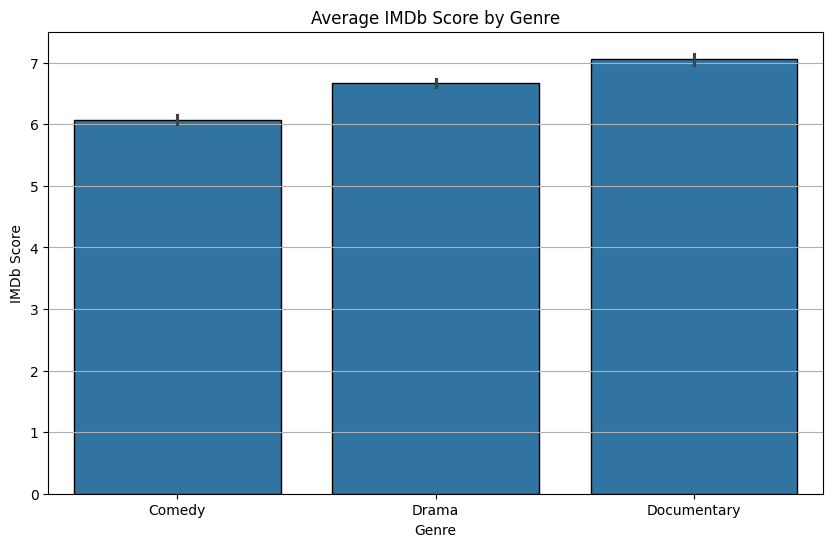

In [189]:
import matplotlib.pyplot as plt

# Defining a dataframe for the display
score_df = pd.DataFrame({
    'Genre': ['Comedy'] * len(comedy_score) + ['Drama'] * len(drama_score) + ['Documentary'] * len(documentary_score),
    'IMDb Score': list(comedy_score) + list(drama_score) + list(documentary_score)
})

# Plotting the data
plt.figure(figsize=(10, 6))
sns.barplot(x='Genre', y='IMDb Score', data=score_df, edgecolor='black')
plt.title('Average IMDb Score by Genre')
plt.xlabel('Genre')
plt.ylabel('IMDb Score')
plt.xticks(rotation=0)
plt.grid(axis='y')

# Displaying the plot
plt.show()

##

## Relationship between rating and box office performance

Here we wish to view the correlation (if any) between the various ratings and the box office performance of a title.

For this we construct a new dataframe with only the rows containing an IMDb, Rotten Tomatoes and Metacritic score, as well as IMDb votes and box office information.
This leaves around 3300 of the original 15500 rows remaining, still enough to investigate trends.

In [190]:
# drop all the rows with missing data
rating_vs_money= df.dropna(subset=['IMDb Score', 'Rotten Tomatoes Score', 'Metacritic Score', 'Boxoffice'])
# rating_vs_money= df.dropna(subset=['IMDb Score', 'Boxoffice'])
print(f'{len(rating_vs_money)} rows remaining')

3335 rows remaining


To make the ratings more comparable, we normalize each of the ratings columns to be in $[0,1]$.

In [191]:
normalize= lambda col: (col - col.min())/(col.max() -col.min())
rating_vs_money['IMDb Score']= normalize(rating_vs_money['IMDb Score'])
rating_vs_money['Rotten Tomatoes Score']= normalize(rating_vs_money['Rotten Tomatoes Score'])
rating_vs_money['Metacritic Score']= normalize(rating_vs_money['Metacritic Score'])

/tmp/ipykernel_26032/3796236192.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_vs_money['IMDb Score']= normalize(rating_vs_money['IMDb Score'])
/tmp/ipykernel_26032/3796236192.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_vs_money['Rotten Tomatoes Score']= normalize(rating_vs_money['Rotten Tomatoes Score'])
/tmp/ipykernel_26032/3796236192.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

Looking at pairwise correlation coefficients, we can see that the different rating sites are fairly strongly correlated with each other.
This is a good sign, as both should in theory be based on the quality of the film in question.

The strongest correlation with box office performance is `IMDb Votes`, a measure of the total number of people who have rated a title on IMDb.
This makes perfect sense, as the more people see a movie the more people will vote on it.

Of the rating sites, IMDb ratings have the strongest correlation with box office performance.

In [192]:
rating_vs_money[['Boxoffice', 'IMDb Score', 'IMDb Votes', 'Metacritic Score', 'Rotten Tomatoes Score']].corr()

,Boxoffice,IMDb Score,IMDb Votes,Metacritic Score,Rotten Tomatoes Score
Boxoffice,1.000000,0.141097,0.607674,0.073913,0.061377
IMDb Score,0.141097,1.000000,0.464091,0.729600,0.746367
IMDb Votes,0.607674,0.464091,1.000000,0.297057,0.252937
Metacritic Score,0.073913,0.729600,0.297057,1.000000,0.907973
Rotten Tomatoes Score,0.061377,0.746367,0.252937,0.907973,1.000000


The scatter plots of box office performance vs ratings (or votes) show this story fairly well.
The red lines are automatically computed linear regression lines, with uncertainty marked in a pink region around the line.

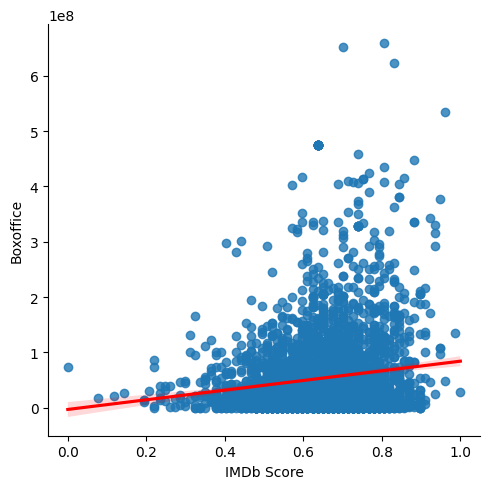

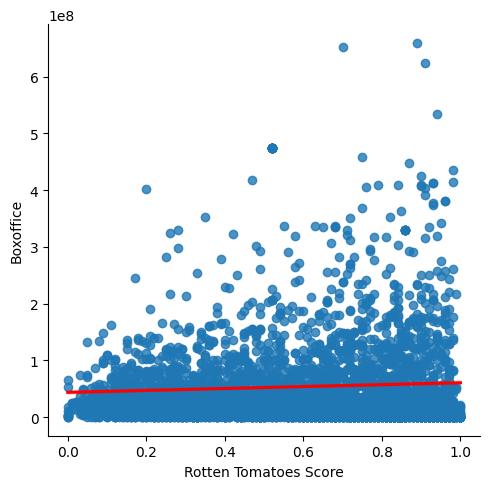

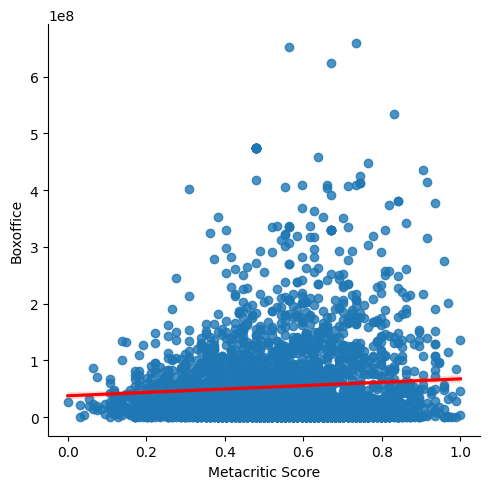

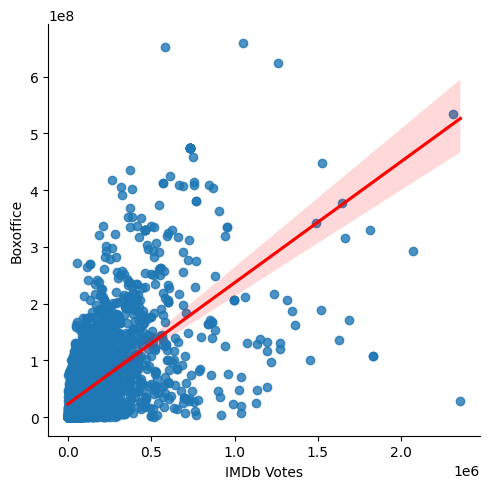

In [193]:
sns.lmplot(rating_vs_money, x='IMDb Score', y='Boxoffice',line_kws={'color': 'red'})
sns.lmplot(rating_vs_money, x='Rotten Tomatoes Score', y='Boxoffice',line_kws={'color': 'red'})
sns.lmplot(rating_vs_money, x='Metacritic Score', y='Boxoffice',line_kws={'color': 'red'})
sns.lmplot(rating_vs_money, x='IMDb Votes', y='Boxoffice',line_kws={'color': 'red'})

These relationships can be succinctly visualized using `seaborn`'s `pairplot()`.

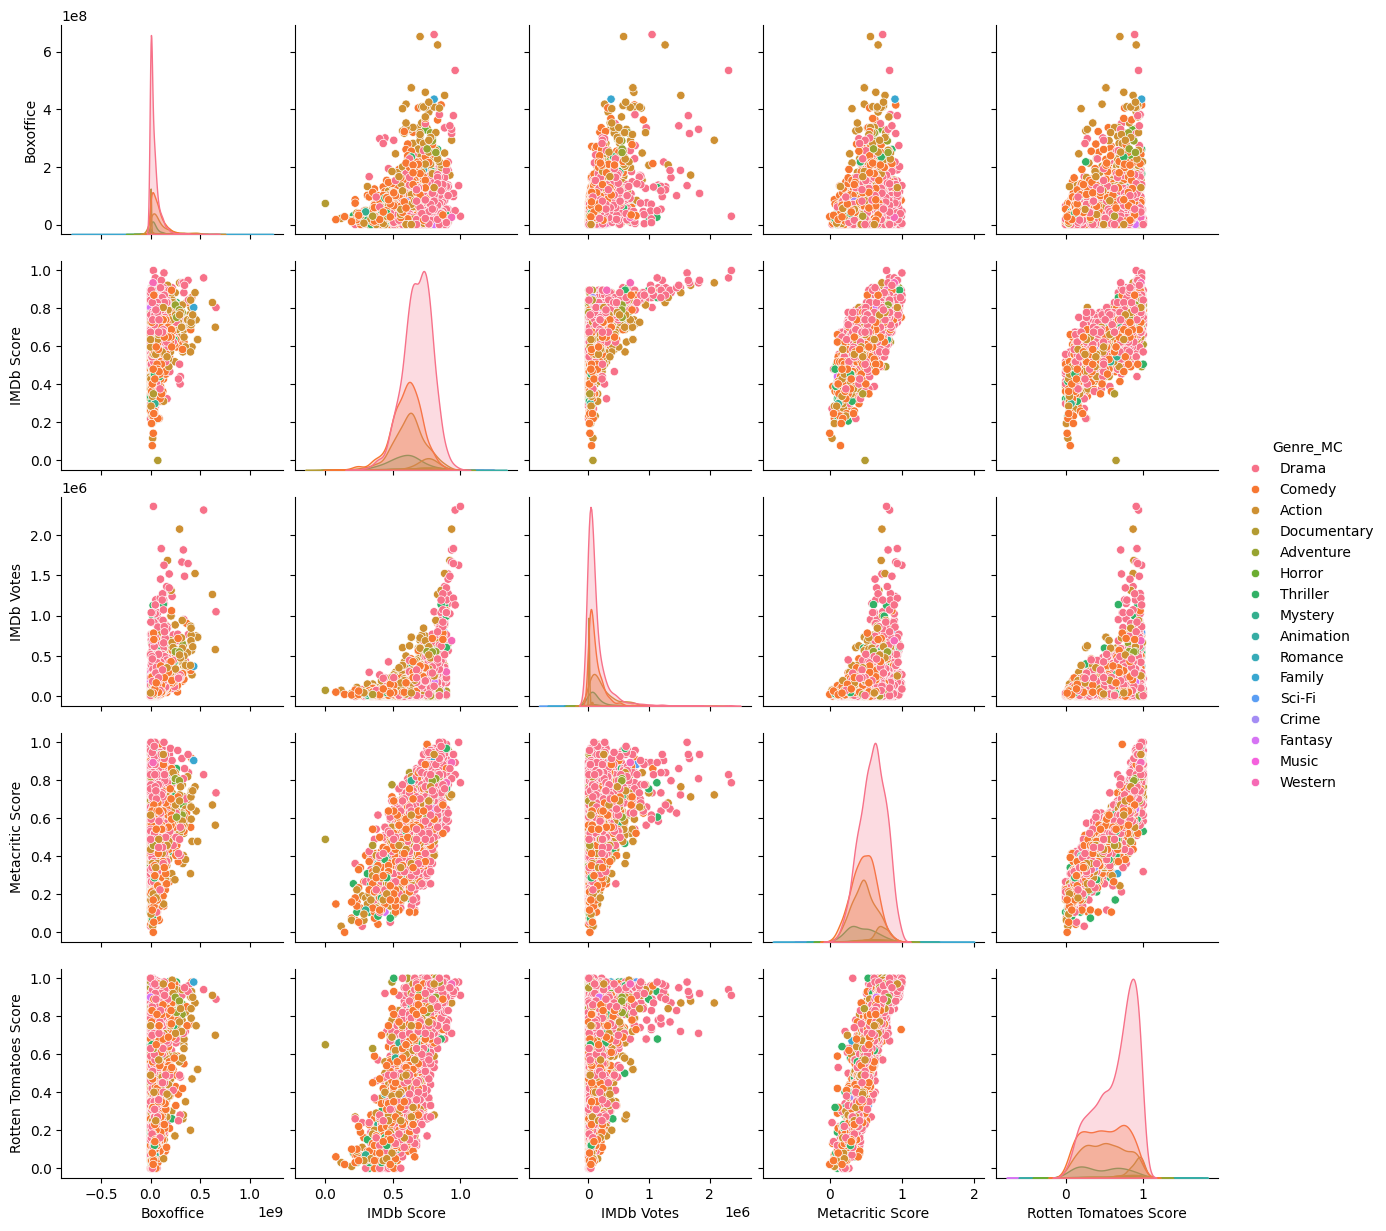

In [194]:
sns.pairplot(rating_vs_money[['Boxoffice', 'IMDb Score', 'IMDb Votes', 'Metacritic Score', 'Rotten Tomatoes Score', 'Genre_MC']], hue='Genre_MC')

## Genre vs Runtime

We want to see if different genres of film have different runtimes.
The runtime column is not very specific (there are only 4 values), but we'll see what we get.

We use the least common of the list of genres for each movie, since it gives the most information.

In [208]:
# we want just the movies
pd.crosstab(df['Genre_LC'], df['Runtime'])

Runtime,1-2 hour,30-60 mins,< 30 minutes,> 2 hrs
Genre_LC,,,,
Action,151,1,17,58
Adult,9,0,5,1
Adventure,187,0,35,57
Animation,93,11,212,2
Biography,184,2,27,93
Comedy,1195,66,283,93
Crime,723,1,184,223
Documentary,377,43,211,15
Drama,594,3,226,190


Now we can plot the distribution for each of the top 10 genres.

We can see that most films are around an hour long, however average runtimes for Animations are significantly lower than the other categories.
The next lowest are family movies and comedies, which makes intuitive sense.

/tmp/ipykernel_26032/1727161247.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Runtime_approx']= data['Runtime'].dropna().apply(lambda x: {'< 30 minutes':0, '1-2 hour':60, '30-60 mins':30, '> 2 hrs': 120}[x])


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'Comedy'),
  Text(1, 0, 'Thriller'),
  Text(2, 0, 'Romance'),
  Text(3, 0, 'Drama'),
  Text(4, 0, 'Family'),
  Text(5, 0, 'Crime'),
  Text(6, 0, 'Fantasy'),
  Text(7, 0, 'Adventure'),
  Text(8, 0, 'Animation'),
  Text(9, 0, 'Action')])

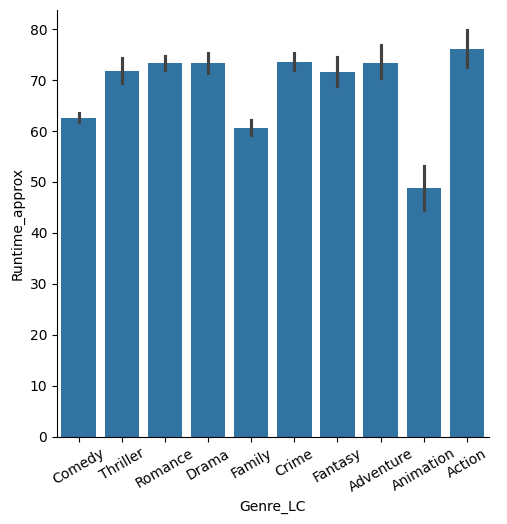

In [216]:
top10= ['Drama', 'Comedy', 'Action', 'Thriller', 'Romance', 'Crime', 'Adventure', 'Animation', 'Fantasy', 'Family']
data= df[(df['Series or Movie'] == 'Movie') & (df['Genre_LC'].isin(top10))]

data['Runtime_approx']= data['Runtime'].dropna().apply(lambda x: {'< 30 minutes':0, '1-2 hour':60, '30-60 mins':30, '> 2 hrs': 120}[x])

sns.catplot(data=data, x='Genre_LC', y='Runtime_approx', kind='bar')
plt.xticks(rotation=30)

# Other

Some additional information for later use:
[This](https://datascience.stackexchange.com/questions/85488/encoding-tags-for-random-forest) seems relevant.

After that we will need to reduce the dimensionality, perhaps with [this](https://medium.com/codex/dimensionality-reduction-techniques-for-categorical-continuous-data-75d2bca53100).